## The following analysis aggregates QC metrics across each experiment and each sample within an experiment. 


In [1]:
filt_prefix = "filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/"
config_f = "parameters/mttrace/aggregate_qc.yaml"

# 0. Library load and preprocessing

In [2]:
covDir_dict = {"TcellDupi":"data/processed/mttrace/PBMC_may17_2021/MTblacklist"}

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import dirname, join
from src.utils.parse_config import read_config_file
import matplotlib as mpl
mpl.use('Agg')
from src.config import ROOT_DIR
from src.utils.data_io import add_id_to_sparse
import os
import numpy as np
from os.path import exists
import tqdm
%load_ext autoreload
%autoreload 2
import subprocess
from src.utils.data_io import load_mtx_df, get_filt_indir, get_cov_indir, preproc_cellr_indir
from mplh.fig_utils import helper_save as hs
from mplh.fig_utils import facet_utils as fu
from src.utils.utils import calc_frip_per_cell 

Project Directory: /data2/mito_lineage


In [4]:
os.chdir(ROOT_DIR)
config = read_config_file(config_f)
output = f"{config['results']}/10x_out/10x_qcAll.png"
outdir = f"{config['results']}/10x_out/"
output

allConfig = {}
for c in config["configfiles"]:
    allConfig[c] = read_config_file(config["configfiles"][c])

# 1. Cellranger QC
The following plots groups samples by their experiment and plots the reported summarized QC results from 10x cellranger software. 

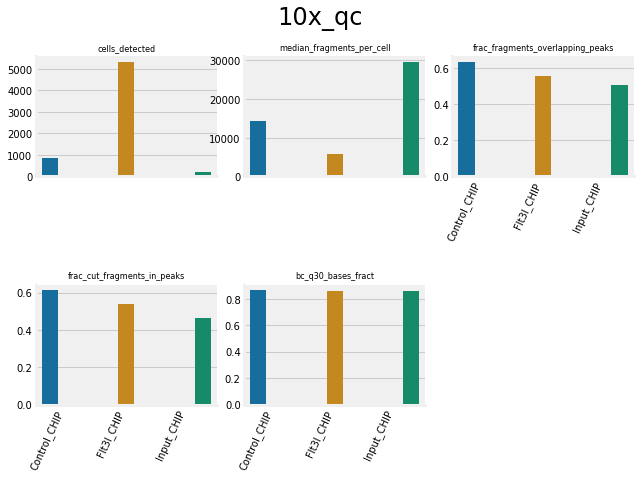

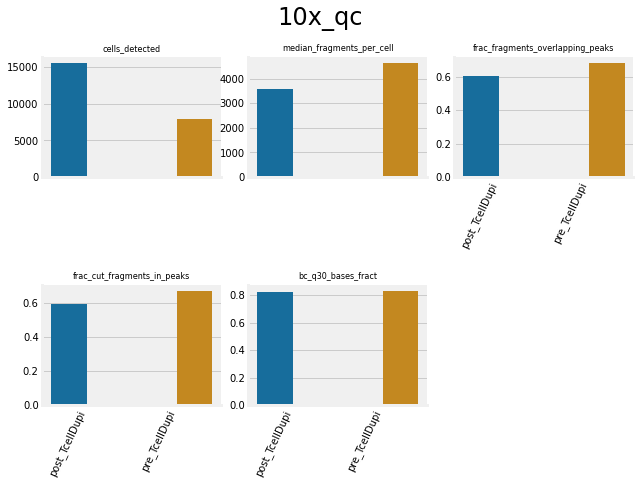

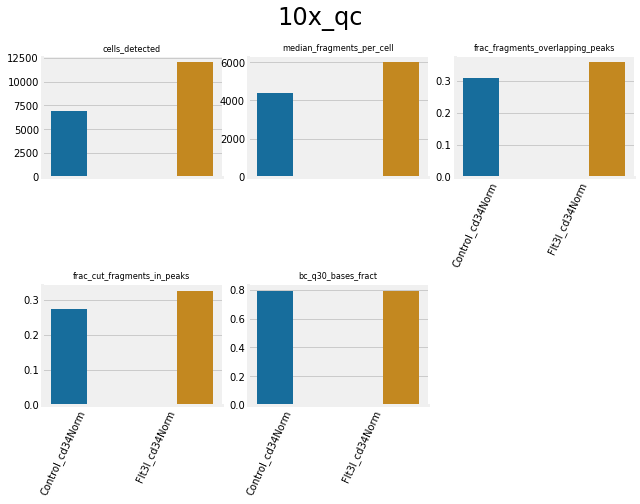

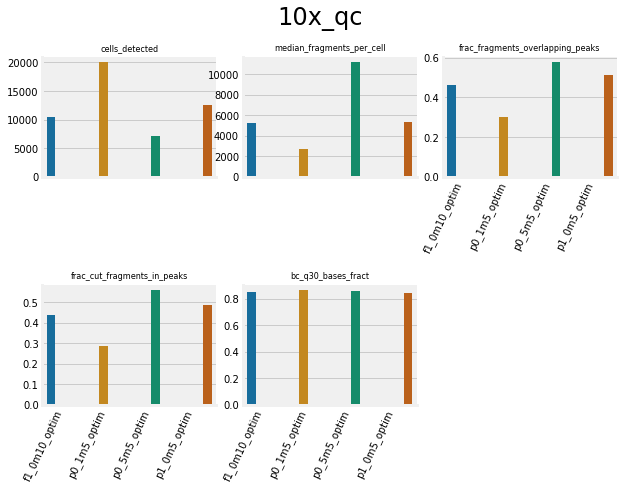

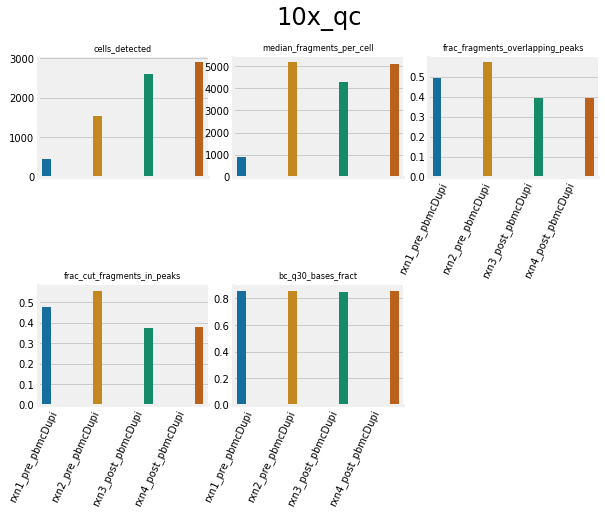

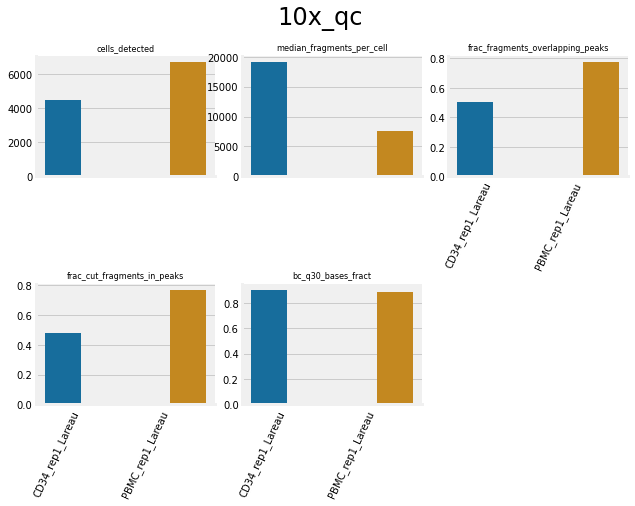

In [5]:
%matplotlib inline
all_samples = pd.DataFrame()
cols = ["cells_detected", "median_fragments_per_cell",
            "frac_fragments_overlapping_peaks",
            "frac_cut_fragments_in_peaks",
            "bc_q30_bases_fract"]
for curr in config["configfiles"]:
    curr_cfg = read_config_file(config["configfiles"][curr])
    samples = pd.read_table(curr_cfg["samples"],sep=',', index_col=0).reset_index()
    samples = samples.dropna(axis=1)
    samples["ID"] = samples["out_name"] + "_" + curr
    samples = samples.set_index("ID", drop=True)
    for ind, val in samples.iterrows():
        samples.at[ind,'metrics'] = join(dirname(val['bam_f']),"summary.csv")
    for ind, val in samples.iterrows():
        df = pd.read_csv(val["metrics"])
        df.index = [ind]
        df.index.name = "ID"
        if df.columns[0] in samples.columns:
            samples.loc[ind, df.columns] = df.loc[ind]
        else:
            samples = samples.merge(df, how='outer', left_index=True, right_index=True)

    samples = samples.drop(labels=["bam_f", "metrics"], axis=1)
    samples_long = samples.reset_index().melt(id_vars="ID", value_vars=cols)
    g = sns.FacetGrid(data=samples_long, col="variable", sharey=False, col_wrap=3, )
    g.map_dataframe(sns.barplot, x="ID", y="value", hue="ID", palette="colorblind")

    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    g = fu(g, g.data, sup_title="10x_qc", title_add_n=False, subtitle_size=8)
    for axes in g.axes.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')
        #axes.set_yticklabels(axes.get_yticklabels(), size=12)
        #axes.get_yticklabels()[0].set_fontsize(12)
    
    
    g.fig.subplots_adjust(hspace=0.9, wspace=.15)#.tight_layout()
    plt.savefig(join(outdir, f"10x_qc_{curr}.png"))
#    plt.close(g)
    all_samples  = pd.concat((all_samples , samples))
    all_samples.loc[samples.index, "data"] = curr
    
#all_samples["ID"] = all_samples["ID"] + "_" + all_samples["data"]
#all_samples.sort_values("data")

## 1.2 This is the summary across all experiments, colored by the experiment

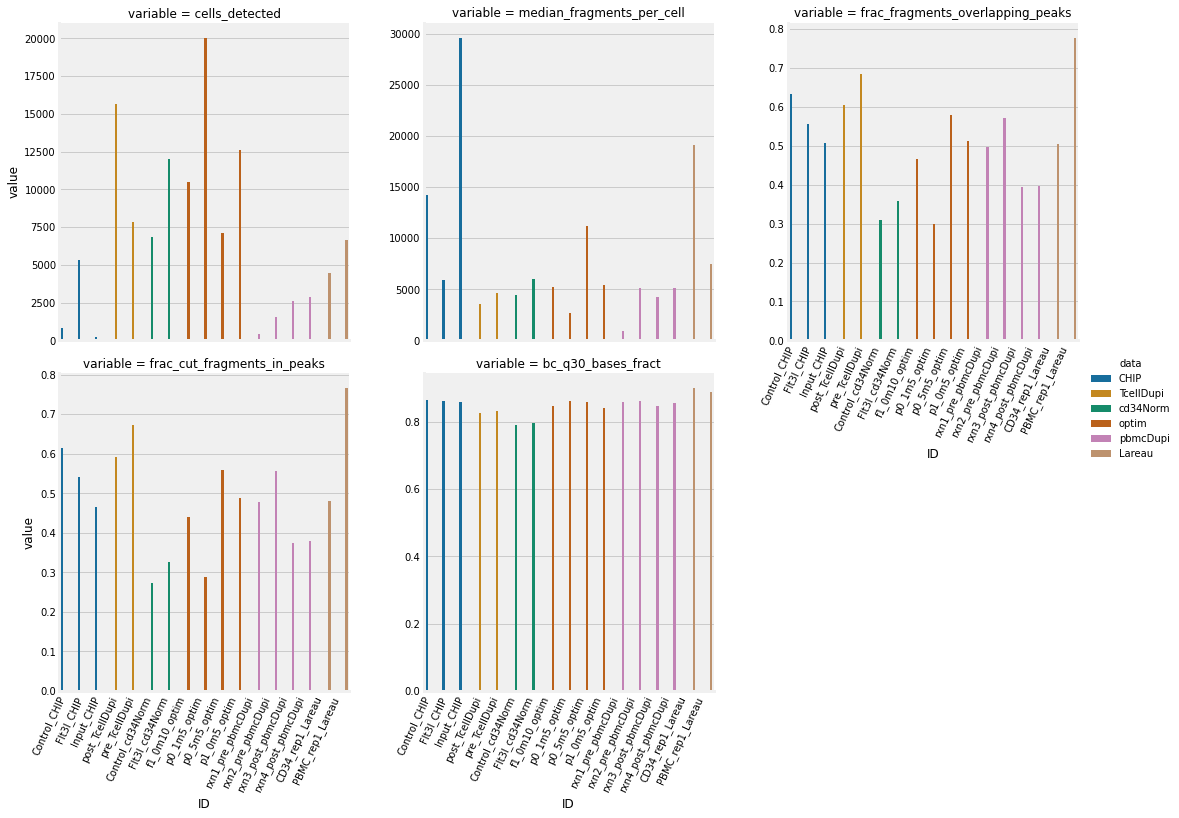

In [6]:
%matplotlib inline
all_samples_long = all_samples.reset_index().melt(id_vars=["out_name", "data"], value_vars=cols)
all_samples_long = all_samples_long.dropna(axis=0)
all_samples_long["data"] = all_samples_long["data"].astype(str)
all_samples_long["ID"] = all_samples_long["out_name"] + "_" + all_samples_long["data"]

g = sns.catplot(x="ID", y="value", col="variable", hue="data",
           data=all_samples_long, kind='bar', col_wrap=3,
   sharey=False, palette="colorblind")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

#g = fu(g, g.data, sup_title="10x_qc", title_add_n=False)
plt.savefig(output)



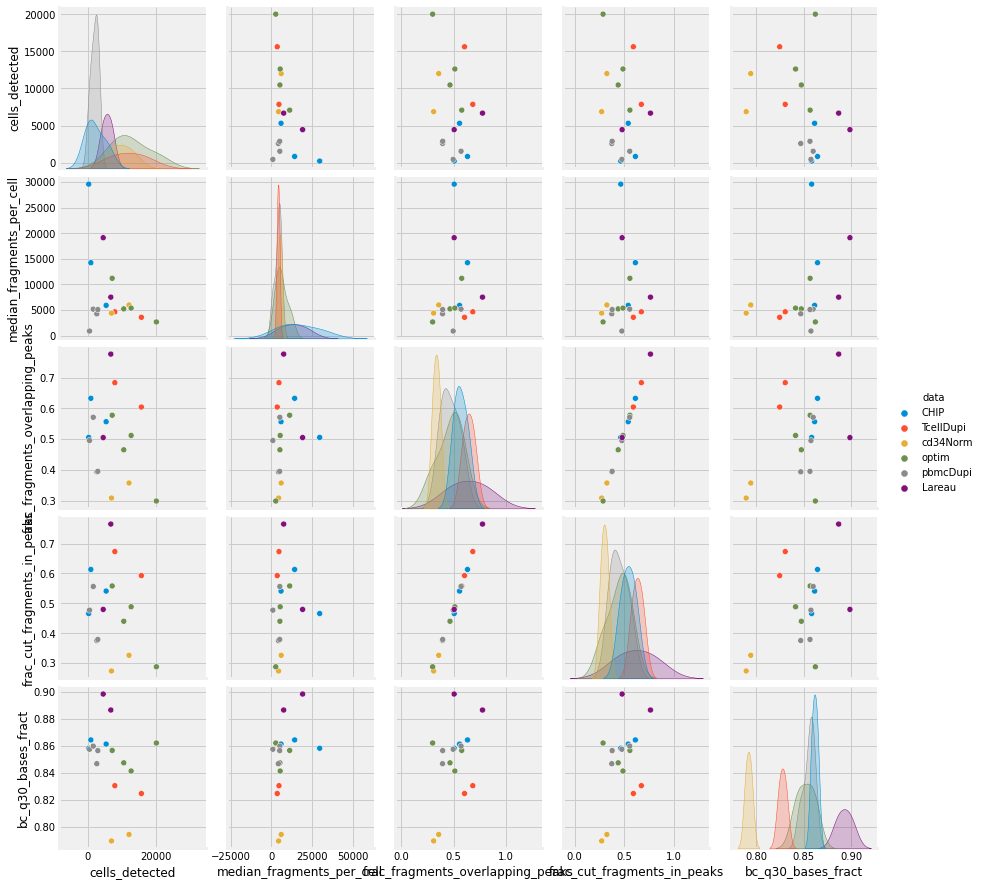

In [7]:
sns.pairplot(all_samples, hue="data", vars=cols)

# Results
There is some heterogeneity across all experiments, and in general we see a slight negative relationship between cells detected and Q30, along with a slight negative relatiobship between cells detected and median fragments per cell (pbmcDupi experiment aside).

------

------

# 2. Peaks-Cells distributions from 10x
In these plots, we calculate the number of unique peaks seen in each cell and plot the #peaks-per-cell distribution

In [8]:
allPeaksPerCell = pd.DataFrame()

for c in allConfig:
    curr_in = allConfig[c]["results"]
    mttrace_in = allConfig[c]["mttrace"]
    #print(curr_in)
    samples = pd.read_table(allConfig[c]["samples"],sep=',', index_col=0).reset_index().set_index("out_name", drop=False)

    for s, df in samples.iterrows():
        #print(c, s)
        peaks = pd.read_csv(join(dirname(samples.loc[s, "barcode_f"]), "peaks.bed"), sep='\t', 
                   header=None)
        cells = pd.read_csv(join(dirname(samples.loc[s, "barcode_f"]), "barcodes.tsv"), header=None)[0]
        cells = cells + "_" + s + "_" + c
        cells.index += 1 #1-based map
        mtx = load_mtx_df(join(dirname(samples.loc[s, "barcode_f"]), "matrix.mtx"), sep=' ', )
        mtx["Sample"] = s
        mtx["exp"] = c        
        mtx = add_id_to_sparse(mtx, cell=cells.to_dict(), cell_col="Cell", cell_name="BC")
        frags_in_peaks_per_cell = mtx.groupby("BC")["Variant"].sum()
        peaks_per_cell = mtx.groupby("BC").apply(lambda x: len(x["Variant"].unique()))
        peaks_per_cell = pd.DataFrame(peaks_per_cell,columns=["Number of peaks"]).pipe(lambda x: x.assign(exp = c,Sample=s))
        peaks_per_cell["Total counts"] = frags_in_peaks_per_cell
        
        allPeaksPerCell = pd.concat((allPeaksPerCell, peaks_per_cell))


allPeaksPerCell["log 2 number of peaks"] = np.log2(allPeaksPerCell["Number of peaks"])
allPeaksPerCell["log 2 Total counts"] = np.log2(allPeaksPerCell["Number of peaks"])


allPeaksPerCell["ID"] = allPeaksPerCell["Sample"]+"_"+allPeaksPerCell["exp"]
#allPeaksPerCell


In [9]:
%matplotlib inline

f, ax = plt.subplots(figsize=(25,25), dpi=300)

sns.violinplot(x="ID", y="log 2 number of peaks", hue="exp",
               data=allPeaksPerCell, palette="colorblind", width=1, dpi=300,
              )
plt.xticks(rotation=65);

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.legend(prop={'size': 24})
plt.tight_layout()
hs(join(outdir, "total_peaks_per_cell"), to_pdf=False)

# Result: The violinplot shows a generally even number of peaks per cell, except the PBMCDupi rxn1 is lower (and gets removed from analysis downstream)

------

------

# 3. Plot MT coverage
## Here we look at the MT coverage in cells that passed the following filters:
1. Number of reads mapping to the MT: >200
2. BQ for a NT to be counted: 20 
3. Positions kept: At least 10 cells with at least 50 reads at a position. 
4. Variants kept: 0.001 heterozygous mean AF in >10 cells
5. Variants kept: >5 reads of the hetereozygous allele in >10 cells. 
6. Positions kept: >20 BQ in >10 cells
7. Cells: 

Mean, Sum, and Variance-Mean Ratio (VMR) per cell and position
## a) cellranger output (computationally intensive)
## b) filters output

## a) Load the coverage files
This is after filters 1&2 listed above, but it takes awhile to run, and the number of cells are not that much different from above. 

In [21]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=24)


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# #######################
# ## coverage for initial 10x cells plus 200 MT reads filter
# #######################
maxBP = 16569
toRawCov = True
# allCoverage = pd.DataFrame()
# allCoverage_d = {}
cellCov = {}
samp_cell_vars = {}
if toRawCov:
    allCovFiles = get_cov_indir(allConfig, covDir_dict)
    allCoverage_d = {}
    for c,s in allCovFiles:
        print(c,s)
        curr_coverage = pd.read_csv(allCovFiles[(c,s)], header=None)
        # Add info to cell ids in case of duplicates
        curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
        
        n_cells = len(curr_coverage[1].unique())
        n_pos = len(curr_coverage[0].unique())
        cells = curr_coverage.groupby(1)
        cell_sum = np.log2(cells.parallel_apply(np.sum)[2]+1)
        cell_mean = cell_sum/maxBP
        cell_var = cells[2].apply(lambda x: ((np.log2(x+1)-cell_mean.loc[x.name])**2)/n_cells)
        cell_vmr = cell_var/cell_mean
        
        #print(f"Cell shape (cell-by-af) {curr_coverage.shape}")
        #curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
        #allCoverage[(c,s)] = curr_coverage
        cell_df = pd.concat((cell_mean.rename("Mean"), cell_vmr.rename("VMR"), 
                             cell_sum.rename("MT Sum")), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
        cell_df["num_positions"] = n_pos
        samp_cell_vars[f"{s}_{c}"] = n_pos
        #cell_df["ID"] = cell_df["Sample"]+"_"+cell_df["exp"]    
        cellCov[(c,s)] = cell_df
    
        # Convert to dense
        #curr_coverage.melt



Using output/mttrace/CHIP_april08_2021/MTblacklist/data/Control/MT/cellr_True/Control_200/Control.coverage.strands.txt.gz
Using data/processed/mttrace/CHIP_april08_2021/MTblacklist/Control/MT/cellr_True/Control_200/Control.coverage.strands.txt.gz
Using data/processed/mttrace/CHIP_april08_2021/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/Flt3l.coverage.strands.txt.gz
Using output/mttrace/CHIP_april08_2021/MTblacklist/data/Input/MT/cellr_True/Input_200/Input.coverage.strands.txt.gz
Using data/processed/mttrace/CHIP_april08_2021/MTblacklist/Input/MT/cellr_True/Input_200/Input.coverage.strands.txt.gz
Using data/processed/mttrace/PBMC_may17_2021/MTblacklist/pre/MT/cellr_True/pre_200/pre.coverage.strands.txt.gz
Using data/processed/mttrace/PBMC_may17_2021/MTblacklist/post/MT/cellr_True/post_200/post.coverage.strands.txt.gz
Using data/processed/mttrace/jan21_2021/MTblacklist/P2/MT/cellr_True/P2_200/P2.coverage.strands.txt.gz
Using data/processed/mttrace/jan21_2021/MTblacklist/J2/MT/cellr_True/J2

In [ ]:
cellCov

In [ ]:

#llCoverage = pd.concat(allCoverage_d).reset_index().rename({0:"Pos", 1:"Cell", 2:"Count", "level_0":"exp", "level_1":"Sample"}, axis=1)

cellCov = pd.concat(cellCov).reset_index(level=[0,1]).rename({"level_0":"exp", "level_1":"Sample"}, axis=1)
cellCov["ID"] = cellCov["Sample"]+"_"+cellCov["exp"]

# posCov = pd.concat(posCov).reset_index(level=[0,1]).rename({"level_0":"exp", "level_1":"Sample"}, axis=1)
# posCov["ID"] = posCov["Sample"]+"_"+posCov["exp"]

%matplotlib inline
g = sns.FacetGrid(data=cellCov,col_wrap=4, col="ID", hue="exp")
g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cellCov, sup_ylabel="Log2 Cell coverage mean", 
       sup_title="Coverage across MT for each cell", 
       title_add_n=True, 
       group_col="ID", 
       group_txt_d = samp_cell_vars, group_txt="#vars")
hs(join(outdir, "cell_cov_vmr_across_pos__R200"), to_pdf=False)

In [ ]:
%matplotlib inline
g = sns.FacetGrid(data=cellCov,col_wrap=4, col="ID", hue="exp")
g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cellCov, sup_ylabel="Log2 Cell coverage mean", 
       sup_title="Coverage across MT for each cell", 
       title_add_n=True, 
       group_col="ID", 
       group_txt_d = samp_cell_vars, group_txt="#vars")
hs(join(outdir, "cell_cov_vmr_across_pos__R200"), to_pdf=False)

In [8]:
allCovFiles[(c,s)]

'data/processed/mttrace/CHIP_april08_2021/MTblacklist/Control/MT/cellr_True/Control_200/Control.coverage.strands.txt.gz'

## b) Filters MT

In [10]:
#######################
## coverage for filtered cells by allele depth, position counts and cell counts
#######################
#allCoverage = {}
allCovFiles = get_filt_indir(allConfig, filt_prefix, covDir_dict)
cellCov = {}
posCov = {}
samp_cell_vars = {}
samp_pos_vars = {}

for c,s in allCovFiles:
    curr_coverage = pd.read_csv(allCovFiles[(c,s)], sep="\t", index_col=0)
    
    # Add info to cell ids in case of duplicates
    curr_coverage.index = curr_coverage.index+"_"+s+"_"+c
    curr_coverage.columns = curr_coverage.columns+"_"+s+"_"+c
    cell_mean = np.log2(curr_coverage+1).mean(axis=1)
    cell_var = np.log2(curr_coverage+1).var(axis=1)
    cell_vmr = cell_var/cell_mean
    cell_sum = np.log2(curr_coverage.sum(axis=1)+1)
    
    #print(f"Cell shape (cell-by-af) {curr_coverage.shape}")
    #curr_coverage[1] = curr_coverage[1]+"_"+s+"_"+c
    #allCoverage[(c,s)] = curr_coverage
    cell_df = pd.concat((cell_mean.rename("Mean"), cell_vmr.rename("VMR"), 
                         cell_sum.rename("MT Sum")), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
    cell_df["num_positions"] = curr_coverage.shape[1] 
    samp_cell_vars[f"{s}_{c}"] = curr_coverage.shape[1] 
    #cell_df["ID"] = cell_df["Sample"]+"_"+cell_df["exp"]    
    cellCov[(c,s)] = cell_df
    
    pos_mean = np.log2(curr_coverage+1).mean(axis=0)
    pos_var = np.log2(curr_coverage+1).var(axis=0)
    pos_vmr = pos_var/pos_mean
    pos_sum = np.log2(curr_coverage+1).sum(axis=0)
    pos_df = pd.concat((pos_mean.rename("Mean"), pos_vmr.rename("VMR"), 
                         pos_sum.rename("MT Sum")), axis=1).reset_index()#.rename(, columns=["Mean", 1:"VMR"}, axis=1)
    #pos_df = pos_df["Sample"]+"_"+pos_df["exp"]    
    pos_df["num_cells"] = curr_coverage.shape[0]
    samp_pos_vars[f"{s}_{c}"] = curr_coverage.shape[0] 
    posCov[(c,s)] = pos_df
    

cellCov = pd.concat(cellCov).reset_index(level=[0,1]).rename({"level_0":"exp", "level_1":"Sample"}, axis=1)
cellCov["ID"] = cellCov["Sample"]+"_"+cellCov["exp"]

posCov = pd.concat(posCov).reset_index(level=[0,1]).rename({"level_0":"exp", "level_1":"Sample"}, axis=1)
posCov["ID"] = posCov["Sample"]+"_"+posCov["exp"]



File for cd34Norm, P2 not here
File for cd34Norm, J2 not here
File for optim, p0_1m5 not here
File for Lareau, CD34_rep1 not here
File for Lareau, PBMC_rep1 not here


# Method+Motivation: 
In this figure, we look to see the MT coverage distribution across each position in a cell, and see it's relationship to the variance across positions (specifically Variance-Mean Ratio, which tries to normalize for larger counts have larger variance).
We would hope that the average mean coverage is high and the VMR is low, b/c we do not want the MT count to vary in a 
cell across positions, which would impede our power to detect variants uniformly.
### n=number of cells kept after filtering
### #vars=number of variant positions kept after filtering

In [11]:
# g = sns.FacetGrid(data=cellCov,col_wrap=4, col="ID", hue="exp")
# g.map_dataframe(sns.scatterplot, x="VMR", y="Mean")
# g.set_axis_labels("VMR", "Log2 Cell coverage mean")
# g = fu(g, cellCov, sup_ylabel="Log2 MT mean coverage", 
#        sup_title="Coverage across MT for each cell", 
#        title_add_n=True, 
#        group_col="ID", 
#        group_txt_d = samp_cell_vars, group_txt="#vars")


## This is the same, but in a kde plot to see if the scatter obscures anything

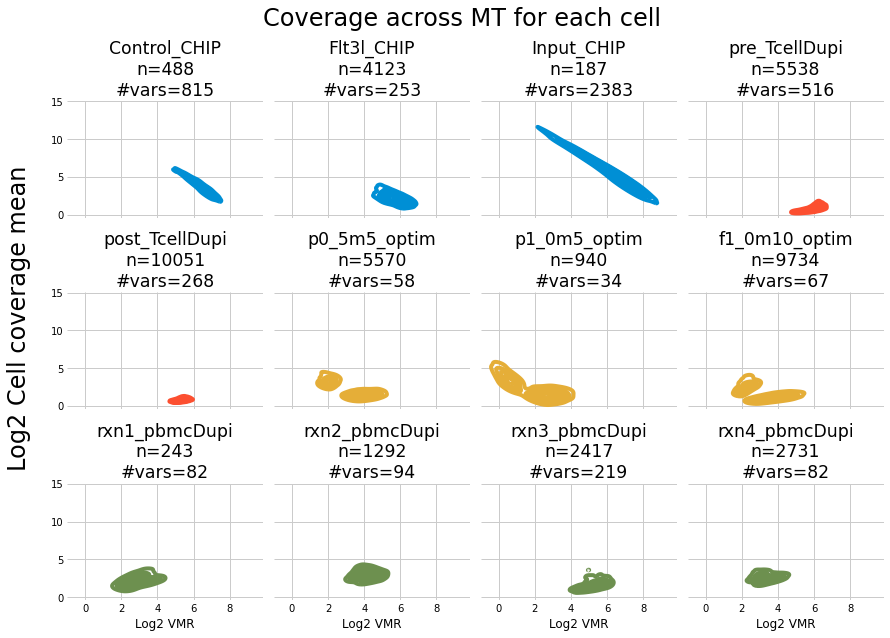

In [12]:
%matplotlib inline
g = sns.FacetGrid(data=cellCov,col_wrap=4, col="ID", hue="exp")
g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cellCov, sup_ylabel="Log2 Cell coverage mean", 
       sup_title="Coverage across MT for each cell", 
       title_add_n=True, 
       group_col="ID", 
       group_txt_d = samp_cell_vars, group_txt="#vars")
hs(join(outdir, "cell_cov_vmr_across_pos"), to_pdf=False)

## Same but on different axes

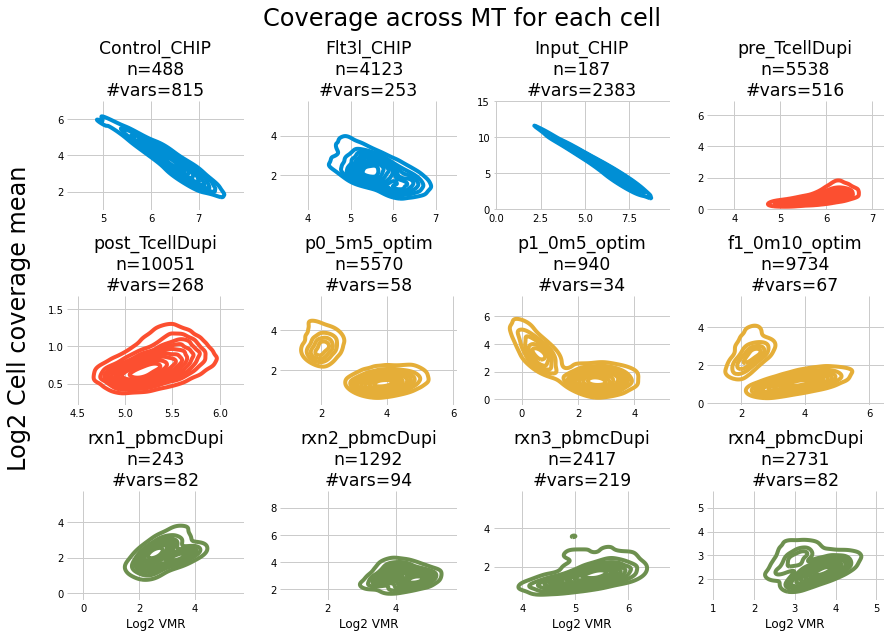

In [13]:
%matplotlib inline
g = sns.FacetGrid(data=cellCov,col_wrap=4, col="ID", hue="exp", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 Cell coverage mean")
g = fu(g, cellCov, sup_ylabel="Log2 Cell coverage mean", 
       sup_title="Coverage across MT for each cell", 
       title_add_n=True, 
       group_col="ID", 
       group_txt_d = samp_cell_vars, group_txt="#vars")
hs(join(outdir, "cell_cov_vmr_across_pos"), to_pdf=False)

# Result:
One takeaway is that the number of variants in p1_0m5 (pfa 1% 5 minutes) loses many cells after MT filtering, and only 940 cells pass the filter. This happens only at the 200 reads map to MT filter, so it is surprising to see that occur. This was confirmed even when not using the cellranger filtered barcodes but all the barcodes found.  
Another takeaway, seen with samples with many variants retained, is a negative relationship between coverage and VMR, along with a wide distribution of MT coverage. The negative relationship is somewhat expected, as variance is higher when the mean is higher, but VMR does not fully normalize that. 
There are also some bi-modal distributions for the pfa data, but that is probably due to the low amount of variants.

---

# Method+Motivation: In this plot we do the same as before, but instead of the means and variance being across MT positions, we calculate it for each position. So each point is now a position in the MT, and the mean is across cells. This is to see if many positions share high coverage, and if the variance is low across cells

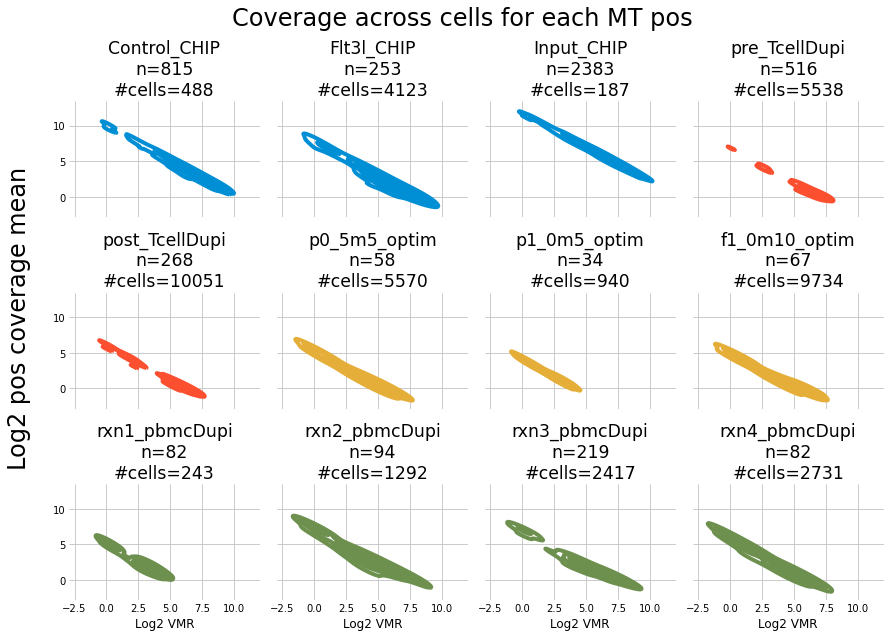

In [14]:
%matplotlib inline
g = sns.FacetGrid(data=posCov,col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.kdeplot, x="VMR", y="Mean")
g.set_axis_labels("Log2 VMR", "Log2 pos coverage mean")
g = fu(g, posCov, sup_ylabel="Log2 pos coverage mean", 
                sup_title="Coverage across cells for each MT pos", title_add_n=True, 
       group_txt_d = samp_pos_vars, group_txt="#cells")
hs(join(outdir, "cell_cov_vmr_across_pos"), to_pdf=False)

# Result:
We see a much clearer pattern between the number of reads and the VMR, which was not ideal, but this is somewhat expected. 

---

# 4. Plot MT coverage vs number of nuclear fragments for each cell
This has been used as a proxy for MT copy number (if we set strong filters)

The goal of this analysis is to see if there is a relationship betwen number of MT fragments sampled and number of nuclear fragments sampled in each cell. We might expect a tradeoff between the two, although this may only happen in aggregate, not per cell.

In [15]:
## Merge the nuclear cell counts and nuclear fragments 

cells_merge_filt__peaks = pd.merge(cellCov, allPeaksPerCell.reset_index().rename({"BC":"Cell"}, axis=1),
                                   on=["Cell", "Sample", "exp", "ID"], how="inner")
#cells_merge_filt__peaks

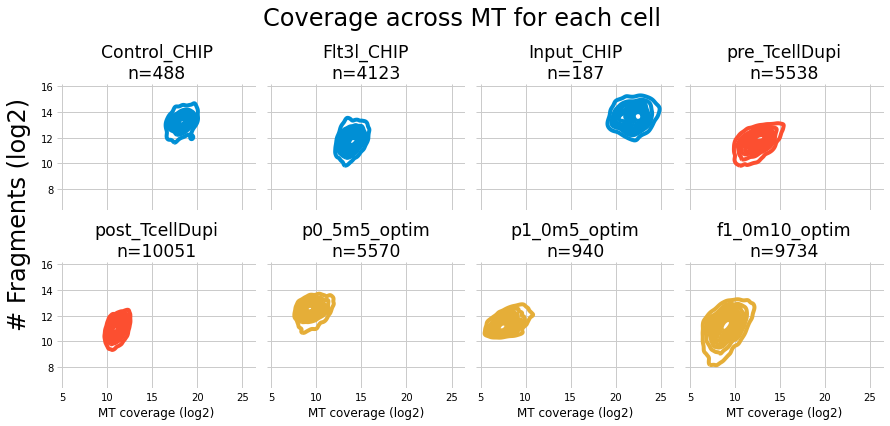

In [16]:
%matplotlib inline
g = sns.FacetGrid(data=cells_merge_filt__peaks, 
                  col_wrap=4, col="ID", hue="exp")

g.map_dataframe(sns.kdeplot, x="MT Sum", y="log 2 Total counts")
g.set_axis_labels("MT coverage (log2)", "# Fragments (log2)")
g = fu(g, g.data, sup_ylabel="# Fragments (log2)", 
                sup_title="Coverage across MT for each cell", title_add_n=True)
hs(join(outdir, "mtSum_vs_nuclearFragsSum"), to_pdf=False)

## Without sharing an axis

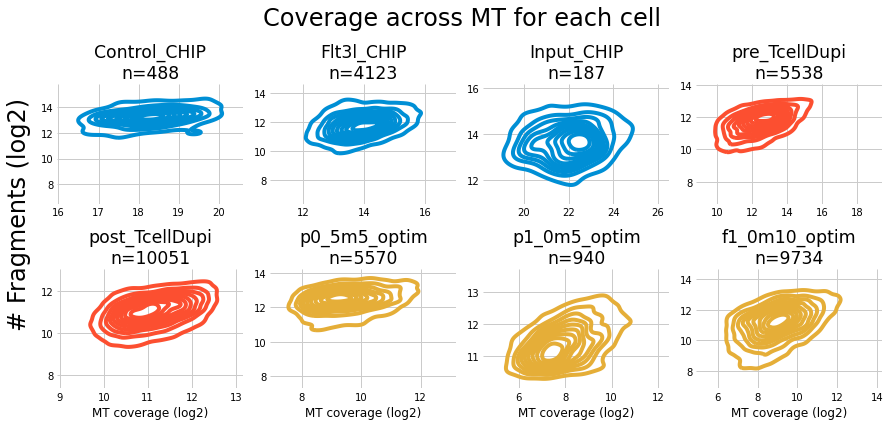

In [17]:
%matplotlib inline
g = sns.FacetGrid(data=cells_merge_filt__peaks, 
                  col_wrap=4, col="ID", hue="exp", sharex=False, sharey=False)
g.fig.subplots_adjust(hspace=0.2)
g.map_dataframe(sns.kdeplot, x="MT Sum", y="log 2 Total counts")
g.set_axis_labels("MT coverage (log2)", "# Fragments (log2)")
g = fu(g, g.data, sup_ylabel="# Fragments (log2)", 
                sup_title="Coverage across MT for each cell", title_add_n=True)
hs(join(outdir, "mtSum_vs_nuclearFragsSum.vAxisDiff"), to_pdf=False)

# Results
When looking at each sample on it's own axes, we see that most appear to be normally distributed in both axes, although there is a slight positive correlation for some, indicating that there is not a trade-off on a per-cell basis necessarily btwn nuclear reads and MT reads in the filtered cells. The tradeoff that we see on a general scale in the 10x output is probably due to the overall number of cells captured. 
This result will be interesting to see in combination with cell types and clusters, to see if MT enrichment is represented in certain cell types (and if that is an artifact or not)

---

---

In [18]:
## lineplot

# %matplotlib inline
# g = sns.FacetGrid(data=pos_df,col_wrap=4, col="ID", hue="exp")

# g.map_dataframe(sns.lineplot, x="VMR", y="Mean")
# # g.set_axis_labels("Log2 VMR", "Log2 pos coverage mean")
# # g = facet_utils(g, pos_df, sup_ylabel="Log2 pos coverage mean", 
# #                 sup_title="Coverage across cells for each MT pos", title_add_n=True)


# Takeaway:
The pfa 1% ended up not having much MT coverage, and the Formaldehyde had 10k cells while the PFA 0.5% had 7,084 cells. The number of cells stayed higher after filtering. Additionally (not shown here), the PFA 1% had a hard time separating the 2 donors in the experiments, while PFA 0.5% and Formaldehyde were able to. The PFA 0.01% had 20k cells and few reads, indicating that a merging of the cells would be possible to recover that, but not recommended. We think the formaldehyde experiment should be used in futre mt-scATAC-seq experiments. 

---------

---------

---------

# 5. (NOT DONE) Calculate FRIP per cell for filters
## a) cellranger output (computationally intensive)
## b) filters output

In [19]:
# def get_frag(indir):
#     df = pd.read_csv(join(indir, "fragments.tsv.gz"), sep="\t")
#     return


# def check_frag_in_peak(frag, peaks):
#     #print(((frag["Start"] <= peaks["End"]) & (frag["End"] >= peaks["Start"])).any())
#     return ((frag["Start"] <= peaks["End"]) & (frag["End"] >= peaks["Start"])).any()
    

# def calc_frip_per_cell(frags, peaks=None, cells=None, to_annotate=False, to_parallel=False):
#     frags = (frags.copy())[frags["Cell"].isin(cells)]
#     if to_annotate: 
#         if to_parallel:
#             frags["in_peak"] = frags.parallel_apply(check_frag_in_peak,args=(peaks,), axis=1)
#         else: 
#             frags["in_peak"] = tqdm.tqdm_pandas(frags.apply(check_frag_in_peak,args=(peaks,), axis=1))
#     cb_frags = frags.groupby("Cell")
#     frags_sum = cb_frags["Count"].sum()
#     #frags_in_read_sum = cb_frags.apply(lambda x: sum([x["Count"] if (x["in_peak"])]))
#     frags_in_read_sum = frags.groupby("in_peak").get_group(True).groupby("Cell")["Count"].sum()
#     frip = frags_in_read_sum/frags_sum
#     #print(frags_sum.head())
#     #print(frags_in_read_sum.head())
#     #print(frip.head())
#     frip_df = pd.concat((frags_sum.rename("Total frags"), frags_in_read_sum.rename("Frags in peak"), 
#                          frip.rename("FRIP")), axis=1)
#     return frip_df


# def plot_frip_per_cell(frip_df, out_f=None):
#     f, ax = plt.subplots(nrows=2, ncols=1)
#     sns.violinplot(frip_df, y="frip", ax=ax[0])
#     sns.scatterplot(frip_df, x="frags_sum", y="frip", ax=ax[1])
#     hs(out_f)
#     return

## b) filt dir

In [20]:

if False:
    frip_per_cell = {}
    allCells = {}

    allFilt_In = get_filt_indir(allConfig, filt_prefix, covDir_dict, use_cov_f=False)
    #cellr_in = get_cellr_indir(allConfig)

    for c,s in allFilt_In:
        print(c,s)
        samples = pd.read_table(allConfig[c]["samples"], sep=',',
                                index_col=0).reset_index().set_index("sample_name", drop=False)
        samples = samples.dropna(axis=1)
        if s in samples.index:
            curr_in = dirname(samples.loc[s, "barcode_f"])
        else:
            curr_in = dirname(
                samples.set_index("sample").loc[s, "barcode_f"])

        curr_frags_f = join(dirname(curr_in), "fragments.tsv.gz")
        curr_cells_f = allFilt_In[(c,s)]
        print(curr_frags_f)
        frags = preproc_cellr_indir(allConfig, c, s)
        cells = (pd.read_csv(allFilt_In[(c,s)], usecols=[0], sep='\t'))
        cells = set((cells["Cell"] + "_" + s + "_" + c).values)
        frags["Cells"] = [x for x in frags["Cells"] if x in cells ]
        frags["Frags"] = frags["Frags"].loc[frags["Frags"]["Cell"].isin(cells)]
        #print(cells)
        print(allFilt_In[(c,s)])
        frip_per_cell[(c,s)] = calc_frip_per_cell(frags["Frags"], frags["Peaks"], cells, to_annotate=True,
                                                 to_parallel=True, nb_workers=36)

    frip_per_cell_df = pd.concat(frip_per_cell).reset_index().rename({"level_0":"exp", "level_1":"Sample"}, axis=1)

    frip_per_cell_df["ID"] = frip_per_cell_df["exp"]+"_"+frip_per_cell_df["Sample"]


    %matplotlib inline
    g = sns.FacetGrid(data=frip_per_cell_df,col_wrap=4, col="ID", hue="exp")
    g.map_dataframe(sns.violinplot,  y="FRIP")
    g.set_axis_labels("FRIP")
    g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True)
    hs(join(outdir, "tmp_frip"))

    g = sns.FacetGrid(data=frip_per_cell_df.assign(frags_log2=lambda x: np.log2(x['Total frags'])),col_wrap=4, col="ID", hue="exp")
    g.map_dataframe(sns.scatterplot, x="frags_log2", y="FRIP")
    g.set_axis_labels("Total frags(log2)", "FRIP")
    g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True, sup_title="FRIP vs total frags")
    hs(join(outdir, "tmp_frags_frip"))

## a) cov dir

In [ ]:
# frip_per_cell = {}
# for c in allConfig:
#     samples = pd.read_table(allConfig[c]["samples"],sep=',', index_col=0).reset_index().set_index("sample_name", drop=False)
#     samples = samples.dropna(axis=1)
#     for s in allConfig[c]["multiplex"]["samples"]:
#         if s in samples.index:
#             curr_in = dirname(samples.loc[s, "barcode_f"])
#         else:
#             curr_in = dirname(samples.set_index("sample").loc[s, "barcode_f"])
#         print(c, s)
#         curr_frags = pd.read_csv(join(dirname(curr_in), "fragments.tsv.gz"), sep="\t", header=None)
#         curr_frags.columns = ["Chr", "Start", "End", "Cell", "Count"]
#         curr_frags["Cell"] = curr_frags["Cell"]+"_"+s+"_"+c
#         peaks = pd.read_csv(join(curr_in, "peaks.bed"), sep="\t", header=None)
#         peaks = peaks.rename({0:"Chr", 1:"Start", 2:"End"}, axis=1)
        
#         cells = pd.read_csv(join(curr_in, "barcodes.tsv"), header=None)[0]
#         cells = cells + "_" + s + "_" + c
#         cells.index += 1 #1-based map
        
#         frip_per_cell[(c,s)] = calc_frip_per_cell(curr_frags, peaks, cells, to_annotate=True)
#     #for s in join(dirname(samples.loc[s, "barcode_f"])

# frip_per_cell_df = pd.concat(frip_per_cell).reset_index().rename({"level_0":"exp", "level_1":"Sample"}, axis=1)

# frip_per_cell_df["ID"] = frip_per_cell_df["exp"]+"_"+frip_per_cell_df["Sample"]
# frip_per_cell_df

In [ ]:
# g = sns.FacetGrid(data=frip_per_cell_df,col_wrap=4, col="ID", hue="exp")
# g.map_dataframe(sns.violinplot,  y="FRIP")
# g.set_axis_labels("FRIP")
# g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True)
# hs(join(outdir, "tmp_frip"))

In [ ]:
# g = sns.FacetGrid(data=frip_per_cell_df.assign(frags_log2=lambda x: np.log2(x['Total frags'])),col_wrap=4, col="ID", hue="exp")
# g.map_dataframe(sns.scatterplot, x="frags_log2", y="FRIP")
# g.set_axis_labels("Total frags(log2)", "FRIP")
# g = fu(g, frip_per_cell_df, sup_ylabel="FRIP per cell", title_add_n=True, sup_title="FRIP vs total frags")
# hs(join(outdir, "tmp_frags_frip"))